In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df = pd.read_csv('fifa_players.csv')
df['id'] = df.index
df.set_index('id', inplace=True)
df.head()

,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
id,,,,,,,,,,,,,,,,,,,,,
0,L. Messi,Lionel Andrés Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,94,48,22,94,94,75,96,33,28,26
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,89,46,56,84,91,67,88,59,57,22
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,82,78,64,82,88,82,87,63,67,67
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,...,84,34,26,83,87,61,83,51,24,22
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,...,15,87,88,24,49,33,80,91,88,87


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17954 entries, 0 to 17953
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           17954 non-null  object 
 1   full_name                      17954 non-null  object 
 2   birth_date                     17954 non-null  object 
 3   age                            17954 non-null  int64  
 4   height_cm                      17954 non-null  float64
 5   weight_kgs                     17954 non-null  float64
 6   positions                      17954 non-null  object 
 7   nationality                    17954 non-null  object 
 8   overall_rating                 17954 non-null  int64  
 9   potential                      17954 non-null  int64  
 10  value_euro                     17699 non-null  float64
 11  wage_euro                      17708 non-null  float64
 12  preferred_foot                 17954 non-null  obje

# Remove irrelevant columns

In [14]:
df.drop(['name', 'full_name', 'birth_date'], axis=1, inplace=True)

# Missing values

<Axes: >

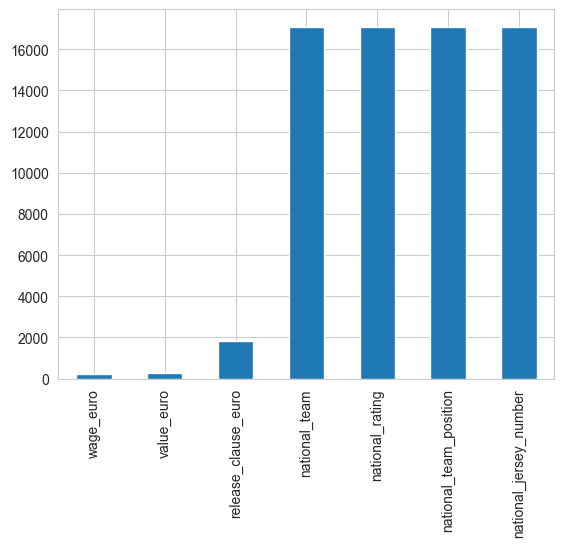

In [15]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)
missing_values.plot.bar()

In [16]:
df.drop(['national_team', 'national_team_position','national_rating', 
         'national_jersey_number'], axis=1, inplace=True)

In [17]:
missing_cols = df.columns[df.isnull().any()]
df[missing_cols].isnull().sum()

value_euro              255
wage_euro               246
release_clause_euro    1837
dtype: int64

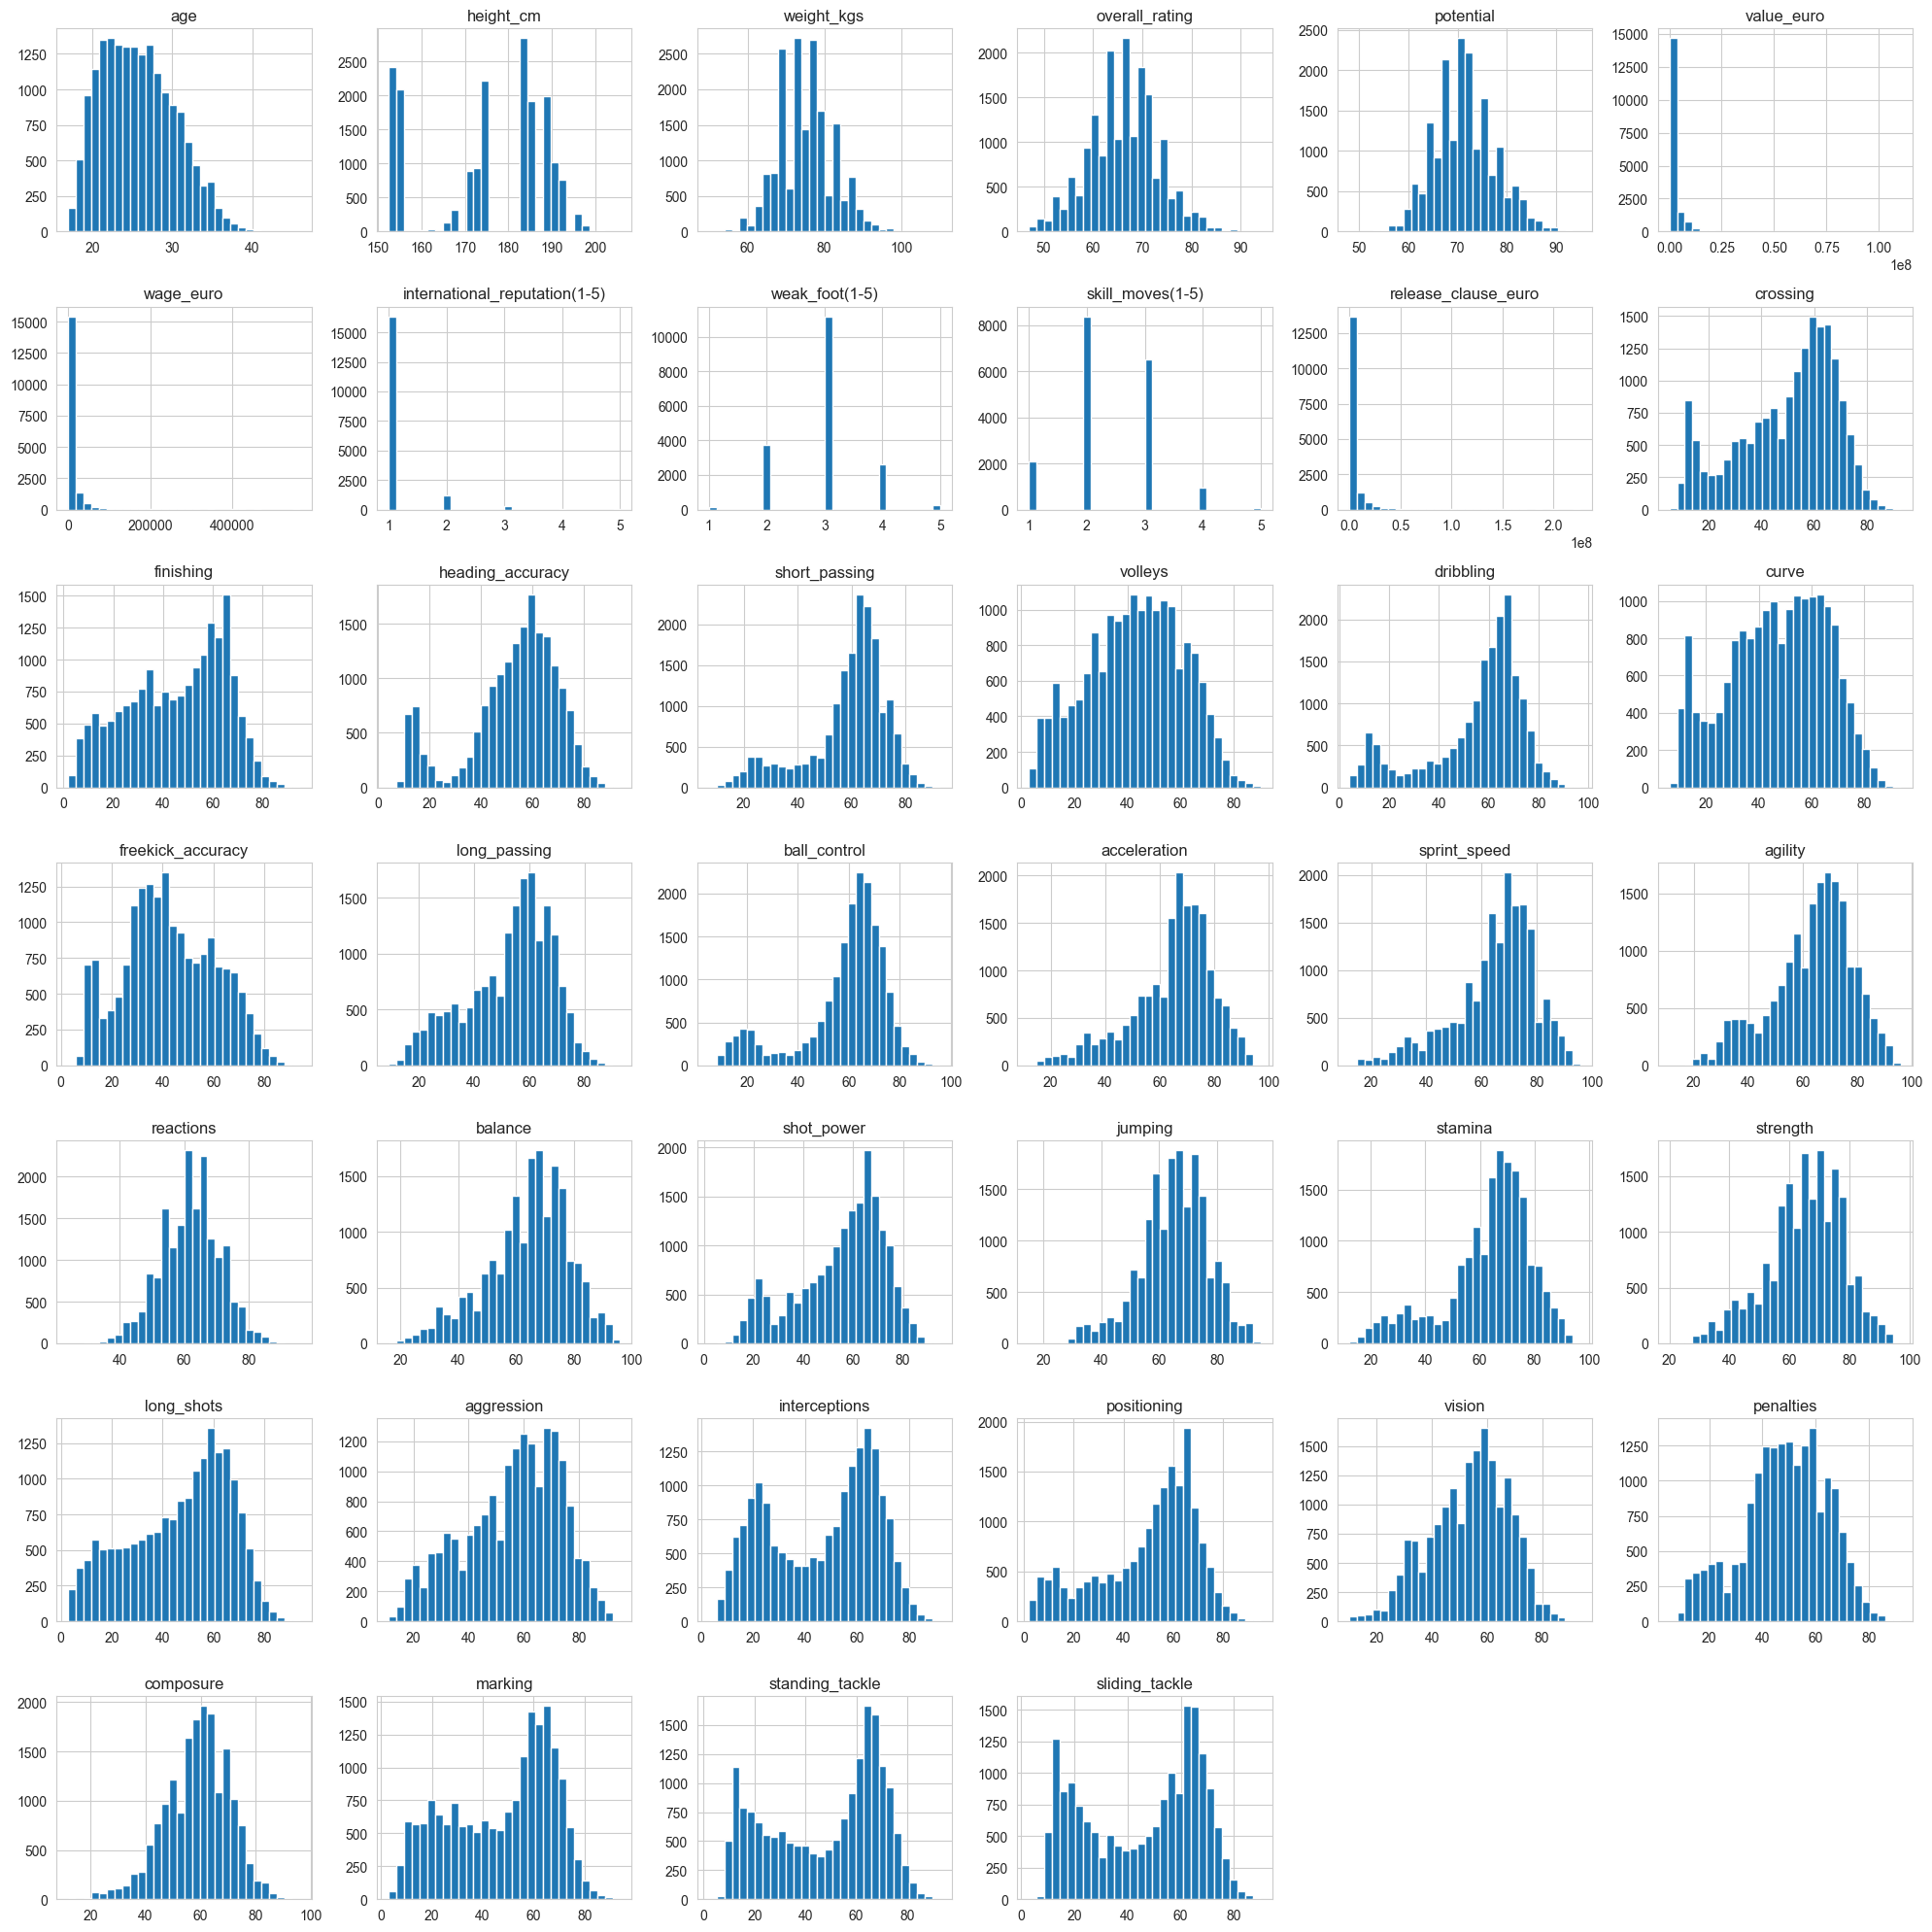

In [18]:
df.hist(bins=30, figsize=(20,20))
plt.tight_layout()
plt.show()

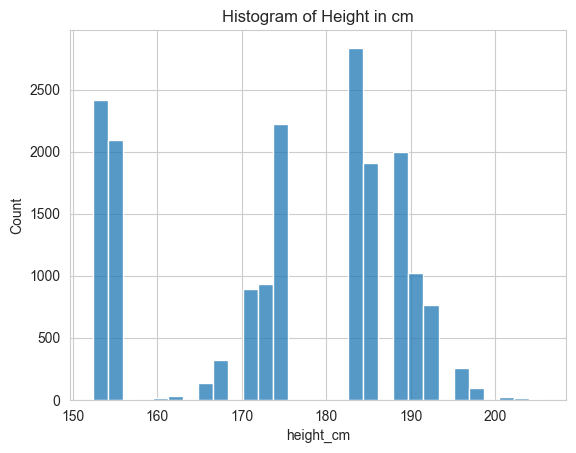

In [19]:
sns.histplot(df['height_cm'], bins=30)
plt.title('Histogram of Height in cm')
plt.show()

In [20]:
height_outliers = df[df['height_cm'] <= 160]
height_outliers = height_outliers[['height_cm']]
height_outliers

,height_cm
id,
1,154.94
6,152.40
15,152.40
17,152.40
29,154.94
...,...
17906,154.94
17910,154.94
17926,154.94


In [21]:
df[df['height_cm'] <= 160].shape

(4515, 44)

In [22]:
df.loc[df['height_cm'] <= 160, 'height_cm'] = np.nan

In [23]:
df.isnull().sum().sort_values(ascending=False)

height_cm                        4515
release_clause_euro              1837
value_euro                        255
wage_euro                         246
positions                           0
weight_kgs                          0
overall_rating                      0
nationality                         0
potential                           0
preferred_foot                      0
international_reputation(1-5)       0
age                                 0
weak_foot(1-5)                      0
skill_moves(1-5)                    0
body_type                           0
crossing                            0
finishing                           0
heading_accuracy                    0
short_passing                       0
volleys                             0
dribbling                           0
curve                               0
freekick_accuracy                   0
long_passing                        0
ball_control                        0
acceleration                        0
sprint_speed

# Miss Forest

In [ ]:
from missforest import MissForest

imputer = MissForest()

columns_to_impute = ['value_euro', 'height_cm', 'wage_euro', 'release_clause_euro']

df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

df[columns_to_impute].isnull().sum()

100%|██████████| 5/5 [00:01<00:00,  3.98it/s]


value_euro             0
height_cm              0
wage_euro              0
release_clause_euro    0
dtype: int64

<Axes: >

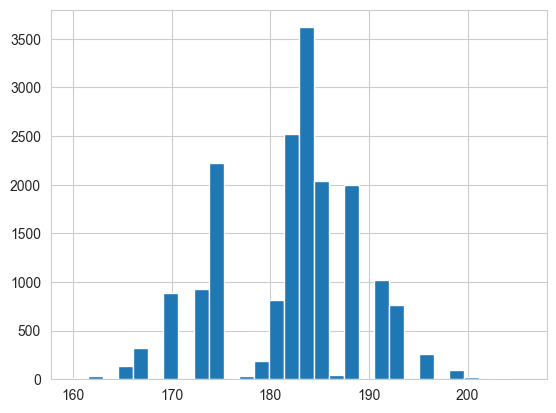

In [25]:
df['height_cm'].hist(bins=30)

<Axes: >

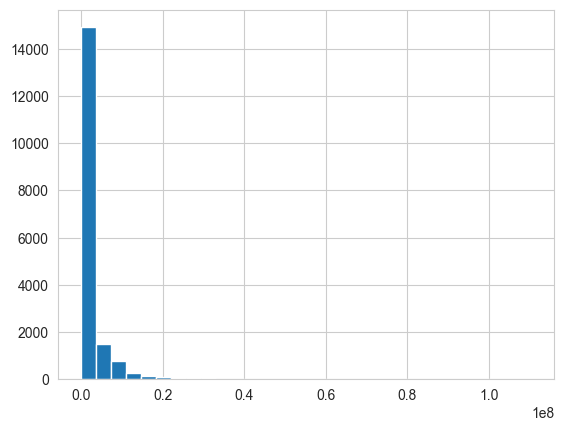

In [26]:
df['value_euro'].hist(bins=30)

<Axes: >

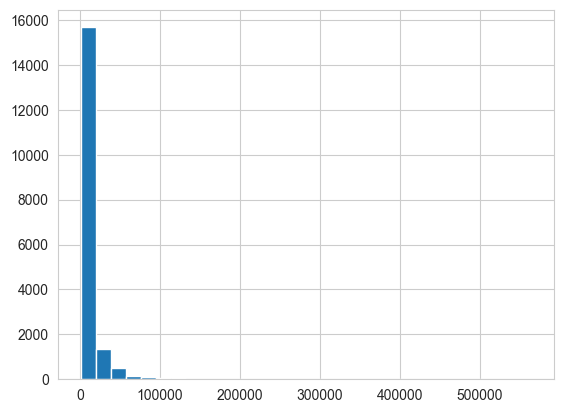

In [27]:
df['wage_euro'].hist(bins=30)

# Chuẩn hoá log (For linear regression)

In [18]:
# Chuẩn hóa log cho các cột
# Sử dụng log1p (tương đương với log(1 + x)) để tránh vấn đề với giá trị 0
df['value_euro_log'] = np.log1p(df['value_euro'])
df['wage_euro_log'] = np.log1p(df['wage_euro'])
df['release_clause_euro_log'] = np.log1p(df['release_clause_euro'])

# Kiểm tra kết quả
df[['value_euro', 'value_euro_log', 'wage_euro', 'wage_euro_log', 'release_clause_euro', 'release_clause_euro_log']].head()


,value_euro,value_euro_log,wage_euro,wage_euro_log,release_clause_euro,release_clause_euro_log
id,,,,,,
0,110500000.0,18.520526,565000.0,13.244583,226500000.0,19.238256
1,69500000.0,18.056837,205000.0,12.230770,133800000.0,18.711857
2,73000000.0,18.105970,255000.0,12.449023,144200000.0,18.786712
3,62000000.0,17.942645,165000.0,12.013707,105400000.0,18.473273
4,60000000.0,17.909855,135000.0,11.813037,106500000.0,18.483656


In [19]:
df.drop(['value_euro', 'wage_euro', 'release_clause_euro'], axis=1, inplace=True)

In [20]:
df.rename(columns={'value_euro_log': 'value_euro', 'wage_euro_log': 'wage_euro',
                     'release_clause_euro_log': 'release_clause_euro'}, inplace=True)

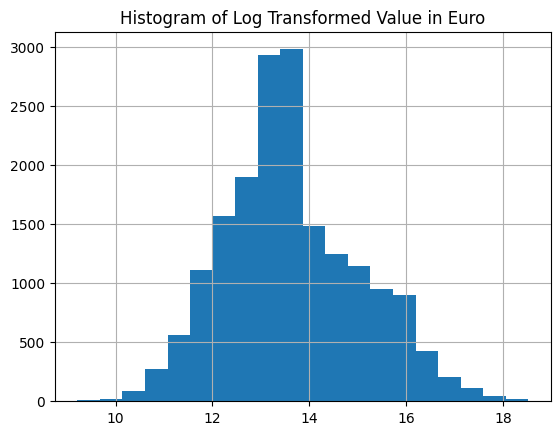

In [21]:
df['value_euro'].hist(bins=20)
plt.title('Histogram of Log Transformed Value in Euro')
plt.show()

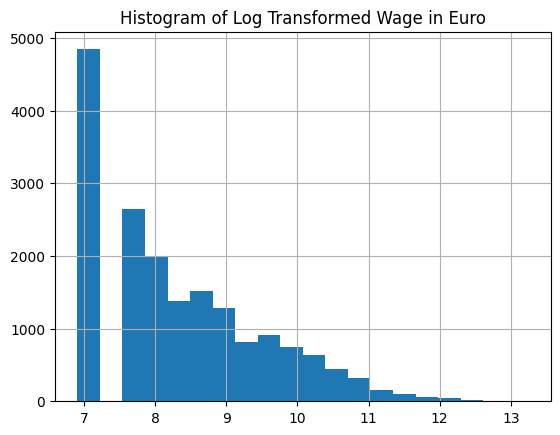

In [22]:
df['wage_euro'].hist(bins=20)
plt.title('Histogram of Log Transformed Wage in Euro')
plt.show()

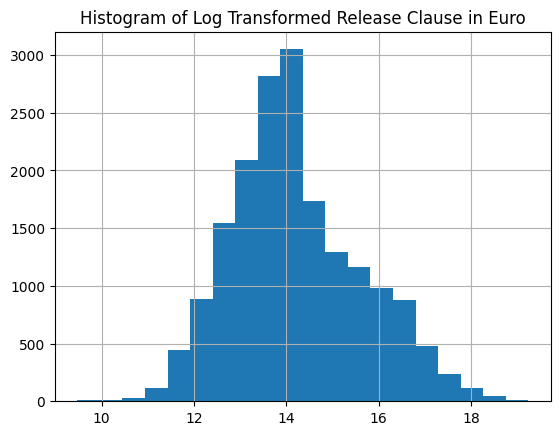

In [23]:
df['release_clause_euro'].hist(bins=20)
plt.title('Histogram of Log Transformed Release Clause in Euro')
plt.show()

# Check duplicated values

In [28]:
df.duplicated().sum()

np.int64(0)

# Object Columns

In [29]:
object_cols = df.select_dtypes(include=['object']).columns
df[object_cols].nunique()

positions         890
nationality       160
preferred_foot      2
body_type          10
dtype: int64

In [26]:
for col in object_cols:
    print(f'{col}: {df[col].unique()}')
    print()

positions: ['CF,RW,ST' 'CAM,RM,CM' 'CM,CAM' 'LW,ST' 'CB' 'RW,ST,RM' 'ST' 'GK'
 'CDM,CM' 'CF,ST' 'RW,ST' 'CAM,RW' 'CDM' 'CM,CDM' 'LB' 'CM,CAM,CDM'
 'CAM,CM,LW' 'CAM,CM,RM' 'LW,ST,LM' 'CAM,CM' 'CAM' 'LW,RW' 'RW,LW' 'CM,LM'
 'CM' 'RM,RW' 'LM,RM,CAM,LW' 'LM' 'RW,RM' 'LM,ST,RM' 'RB' 'LM,RM,LW,RW'
 'LM,CAM,RM' 'RM,LM,ST' 'RW' 'LM,ST,RM,LW' 'CM,CDM,CAM' 'CM,CDM,CB'
 'CB,CDM' 'CF,ST,CAM' 'CDM,CB' 'RB,RWB' 'RM' 'LM,CAM' 'CM,LW' 'LB,LWB,LM'
 'ST,LW' 'LM,LB,CM' 'RB,RM' 'RM,LM,CM' 'LM,RM,CAM' 'RM,RW,ST' 'LW,LM,RW'
 'LB,LM' 'ST,LW,LM' 'RM,CM' 'CM,RM' 'CB,RB' 'RM,RW,LM' 'LM,RM' 'CDM,CB,CM'
 'CAM,CDM' 'LB,CDM' 'CAM,RM,LM' 'RM,CAM,CM' 'LWB' 'CDM,CM,LM' 'CDM,CM,RM'
 'CDM,CM,CB' 'CAM,LW' 'RM,LM' 'ST,CAM' 'LM,CM' 'ST,CF,CAM,LM'
 'LWB,LB,CB,LM' 'RB,LB' 'LW' 'CAM,ST' 'LM,RM,LW' 'LWB,LM,LB'
 'ST,CF,LM,CAM' 'LM,LW,ST' 'LB,LWB' 'RWB,RB,RM' 'ST,RW' 'CAM,CM,LM'
 'RB,RW' 'RM,CAM,LM' 'ST,RM' 'RM,ST' 'CM,LM,RM' 'CM,CAM,LM' 'RW,RWB'
 'LM,RB' 'RM,LM,RW,CAM' 'ST,RM,RWB,LM' 'LB,RB' 'CM,CDM,RM' 'LM,LW'
 'CAM,ST,RM' 'ST

In [30]:
valid_body_types = ['Lean', 'Normal', 'Stocky']
df = df[df['body_type'].isin(valid_body_types)]
df['body_type'].unique()

array(['Lean', 'Normal', 'Stocky'], dtype=object)

In [31]:
df['body_type'].value_counts()

body_type
Normal    10393
Lean       6468
Stocky     1086
Name: count, dtype: int64

In [32]:
df['preferred_foot'].value_counts()

preferred_foot
Right    13778
Left      4169
Name: count, dtype: int64

In [33]:
df['international_reputation(1-5)'].value_counts() # imbalance

international_reputation(1-5)
1    16369
2     1226
3      299
4       50
5        3
Name: count, dtype: int64

## Feature engineering

In [31]:
# def is_star_player(player):
#     return player['international_reputation(1-5)'] >= 3 or player['value_euro'] >= 1e7 or player['wage_euro'] >= 1e5

# df['is_star_player'] = df.apply(is_star_player, axis=1)

In [32]:
# df['is_star_player'].value_counts()

In [34]:
df.drop(['international_reputation(1-5)'], axis=1, inplace=True)

## preferred foot

In [35]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['preferred_foot'] = le.fit_transform(df['preferred_foot'])
df['preferred_foot'].value_counts()

preferred_foot
1    13778
0     4169
Name: count, dtype: int64

## body type

In [35]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()

# df['body_type'] = le.fit_transform(df['body_type'])
# df['body_type'].value_counts()


In [36]:
df_encoded = pd.get_dummies(df, columns=['body_type'])
df_encoded.head()

,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,value_euro,wage_euro,preferred_foot,...,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle,body_type_Lean,body_type_Normal,body_type_Stocky
id,,,,,,,,,,,,,,,,,,,,,
1,27,177.606642,76.2,"CAM,RM,CM",Denmark,88,89,69500000.0,205000.0,1,...,84,91,67,88,59,57,22,True,False,False
2,25,190.500000,83.9,"CM,CAM",France,88,91,73000000.0,255000.0,1,...,82,88,82,87,63,67,67,False,True,False
3,27,162.560000,59.0,"LW,ST",Italy,88,88,62000000.0,165000.0,1,...,83,87,61,83,51,24,22,False,True,False
4,27,187.960000,88.9,CB,Senegal,88,91,60000000.0,135000.0,1,...,24,49,33,80,91,88,87,False,True,False
5,27,193.040000,92.1,CB,Netherlands,88,90,59500000.0,215000.0,1,...,41,60,62,87,90,89,84,False,True,False


In [37]:
df = df_encoded.copy()

## positions

In [38]:
object_cols = df.select_dtypes(include=['object']).columns
object_cols

Index(['positions', 'nationality'], dtype='object')

In [39]:
df['positions'] = df['positions'].str.split(',')
df['positions']

id
1        [CAM, RM, CM]
2            [CM, CAM]
3             [LW, ST]
4                 [CB]
5                 [CB]
             ...      
17949    [RM, CAM, CM]
17950             [LB]
17951             [GK]
17952         [ST, LM]
17953             [ST]
Name: positions, Length: 17947, dtype: object

In [40]:
df_exploded = df.explode('positions')
df_encoded = pd.get_dummies(df_exploded, columns=['positions'])

one_hot_columns = [col for col in df_encoded.columns if col.startswith('positions_')]
df_one_hot_sum = df_encoded[one_hot_columns].groupby('id').sum()
df_final = df.drop(columns=['positions']).join(df_one_hot_sum)

df = df_final

In [42]:
import pandas as pd
pd.set_option('display.max_columns', None)
df.head()

,age,height_cm,weight_kgs,nationality,overall_rating,potential,value_euro,wage_euro,preferred_foot,weak_foot(1-5),skill_moves(1-5),release_clause_euro,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,freekick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle,body_type_Lean,body_type_Normal,body_type_Stocky,positions_CAM,positions_CB,positions_CDM,positions_CF,positions_CM,positions_GK,positions_LB,positions_LM,positions_LW,positions_LWB,positions_RB,positions_RM,positions_RW,positions_RWB,positions_ST
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,27,177.606642,76.2,Denmark,88,89,69500000.0,205000.0,1,5,4,133800000.0,88,81,52,91,80,84,86,87,89,91,76,73,80,88,81,84,50,92,58,89,46,56,84,91,67,88,59,57,22,True,False,False,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,25,190.500000,83.9,France,88,91,73000000.0,255000.0,1,4,5,144200000.0,80,75,75,86,85,87,85,82,90,90,71,79,76,82,66,90,83,88,87,82,78,64,82,88,82,87,63,67,67,False,True,False,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,27,162.560000,59.0,Italy,88,88,62000000.0,165000.0,1,4,4,105400000.0,86,77,56,85,74,90,87,77,78,93,94,86,94,83,93,75,53,75,44,84,34,26,83,87,61,83,51,24,22,False,True,False,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,27,187.960000,88.9,Senegal,88,91,60000000.0,135000.0,1,3,2,106500000.0,30,22,83,68,14,69,28,28,60,63,70,75,50,82,40,55,81,75,94,15,87,88,24,49,33,80,91,88,87,False,True,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,27,193.040000,92.1,Netherlands,88,90,59500000.0,215000.0,1,3,2,114500000.0,53,52,83,79,45,70,60,70,81,76,74,77,61,87,49,81,88,75,92,64,82,88,41,60,62,87,90,89,84,False,True,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


# nationality

In [43]:
object_cols = df.select_dtypes(include=['object']).columns
object_cols

Index(['nationality'], dtype='object')

In [44]:
df['nationality'].nunique()

160

In [45]:
df['nationality'].unique()

array(['Denmark', 'France', 'Italy', 'Senegal', 'Netherlands',
       'Argentina', 'Germany', 'Uruguay', 'Spain', 'Slovakia', 'Brazil',
       'Croatia', 'Belgium', 'Costa Rica', 'Colombia', 'Morocco',
       'Portugal', 'Sweden', 'Bosnia Herzegovina', 'Mexico', 'England',
       'Austria', 'Iceland', 'Hungary', 'Wales', 'Ukraine',
       'Central African Rep.', 'Serbia', 'Ivory Coast', 'Cameroon',
       'Paraguay', 'Australia', 'Algeria', 'Romania', 'Russia', 'Israel',
       'Switzerland', 'Chile', 'Tunisia', 'Turkey', 'Nigeria', 'Peru',
       'Norway', 'Greece', 'United States', 'Venezuela', 'Iran', 'Egypt',
       'Equatorial Guinea', 'Cape Verde', 'Tanzania', 'Scotland',
       'China PR', 'Kosovo', 'Montenegro', 'Canada', 'Madagascar', 'Mali',
       'Ghana', 'Guinea', 'Poland', 'Cuba', 'Northern Ireland', 'Japan',
       'New Zealand', 'South Africa', 'Republic of Ireland', 'Ecuador',
       'Burkina Faso', 'Czech Republic', 'Slovenia', 'Belarus', 'Gabon',
       'FYR Macedoni

In [46]:
df['nationality'].value_counts()

nationality
England                 1657
Germany                 1199
Spain                   1070
France                   925
Argentina                903
                        ... 
Kuwait                     1
New Caledonia              1
Oman                       1
São Tomé & Príncipe        1
United Arab Emirates       1
Name: count, Length: 160, dtype: int64

In [441]:
df['value_euro'].corr(df['release_clause_euro'])

np.float64(0.9921626459300964)

In [442]:
# df.drop(['release_clause_euro'], axis=1, inplace=True)

# Create new data

In [443]:
df.to_csv('data.csv', index=False)